In [1]:
fdir = "../hanglog/mild_swinging"

import os, sys
sys.path.append("..")
import hacktrack.loaders
import pandas, numpy, math
import scipy.optimize
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
from hacktrack.utils import qvec, qmult, InterpT, curvefitdifferentiate
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

logfiles = os.listdir(fdir)
print(logfiles)
fLog = os.path.join(fdir, logfiles[0])
fd = loaders.FlyDat(fLog)
fd.LoadC("ZY")

# assign timevalues in seconds to these tables
fd.pY["t"] = (fd.pY.index - fd.t0)/pandas.Timedelta(seconds=1)
fd.pZ["t"] = (fd.pZ.index - fd.t0)/pandas.Timedelta(seconds=1)

# filter the spikes
Z0 = fd.pY[~fd.pY.bad]
Z1 = fd.pZ[~fd.pZ.bad]


t0 = fd.t0 + pandas.Timedelta(seconds=2)
t1 = t0 + pandas.Timedelta(seconds=18)
A = Z1[t0:t1]

['hdata-2021-01-05_19-24-22.log']
Extracting knowndate from filename: 2021-01-05
E:1, Y:17596, Z:17374, aZ:1026, aA:1026, aF:1009
linAdifftime 28119431.929856114 count 1112
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index 0
Made for aV 0 last index 0
Missing GPS data, so setting t0 to 2021-01-05 19:22:58.029930
Made for Z 17374 last index 17374
Warning, using guessed (not GPS) timing corrected value on Z 17374
pCattrname pZ
Made for Y 17596 last index 17596
Warning, using guessed (not GPS) timing corrected value on Y 17596
pCattrname pY


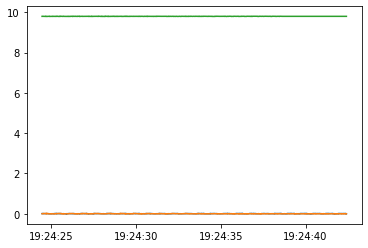

In [2]:
# Transform and plot the gravity acceleration vector that is expressed in device coordinates
# into real world coordinates where it will be aligned with the up vector
a = qvec((A.q0, -A.q1, -A.q2, -A.q3), (A.gx,A.gy,A.gz))
plt.plot(a[0])
plt.plot(a[1])
plt.plot(a[2])

In [3]:
# If the orientation of the device were perfectly aligned with the pendulum
# then the acceleration would be towards the centre and proportional to the distance

# first the savgol filtering of the Z vector of the board transformed back to real space 
# giving the smoothed, velocity and acceleration terms
b = qvec((A.q0, -A.q1, -A.q2, -A.q3), (0,0,1))
bx0, bx1, bx2 = curvefitdifferentiate(b[0], 0.18)
by0, by1, by2 = curvefitdifferentiate(b[1], 0.18)
bz0, bz1, bz2 = curvefitdifferentiate(b[2], 0.18)

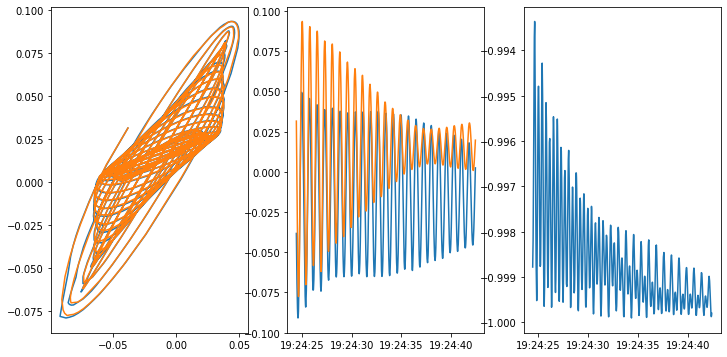

In [4]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(b[0], b[1])
plt.plot(bx0, by0)
plt.subplot(132)
plt.plot(bx0)
plt.plot(by0)
plt.subplot(133)
plt.plot(bz0)

residuals  0.022094352780225236 0.022299709240590448


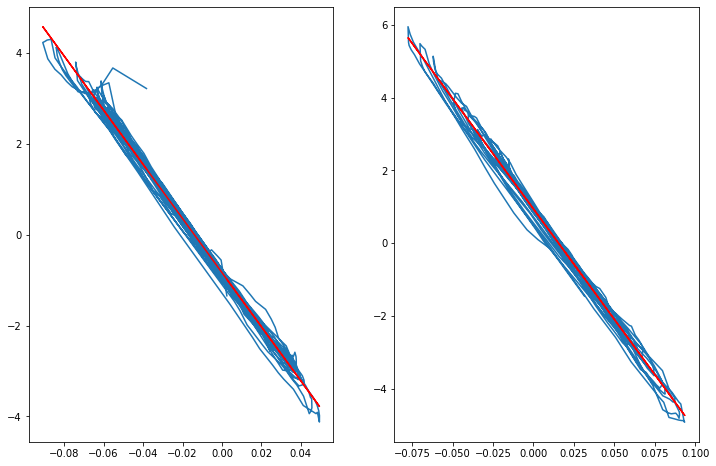

In [5]:
# Here is the graph between the coordinate and the acceleration, which should be linear
plt.figure(figsize=(12,8))

plt.subplot(121)
plt.plot(bx0, bx2)

bxlm, resx = numpy.polyfit(bx0, bx2, 1, full=True)[:2]
plt.plot(bx0, numpy.poly1d(bxlm)(bx0), color="red")

plt.subplot(122)
plt.plot(by0, by2)

bylm, resy = numpy.polyfit(by0, by2, 1, full=True)[:2]
plt.plot(by0, numpy.poly1d(bylm)(by0), color="red")

print("residuals ", float(resx)/len(bx0), float(resy)/len(bx0))

In [6]:
# But we should do better than this.  
# Is there a small change in the alignment of the board that will make it fit more accurately?

# Suppose we pick (hx, hy, sqrt(1-hx**2-hy**2)) instead of (0,0,1)

# quick attempt at making the swinging more central
import scipy.optimize
def fun(X):
    hx, hy = X
    hz = math.sqrt(max(0, 1-hx**2-hy**2))
    b = qvec((A.q0, -A.q1, -A.q2, -A.q3), (hx, hy, hz))
    return sum(b[0])**2 + sum(b[1])**2
res = scipy.optimize.minimize(fun, [0,0], method="Nelder-Mead")
print(res)

 final_simplex: (array([[-0.01796694,  0.01110239],
       [-0.01796912,  0.0111116 ],
       [-0.0179623 ,  0.01111078]]), array([1.72796734e-05, 8.63648957e-05, 1.03918502e-04]))
           fun: 1.7279673353205678e-05
       message: 'Optimization terminated successfully.'
          nfev: 68
           nit: 35
        status: 0
       success: True
             x: array([-0.01796694,  0.01110239])


-0.0041135187268487895 -0.0006293657305206594


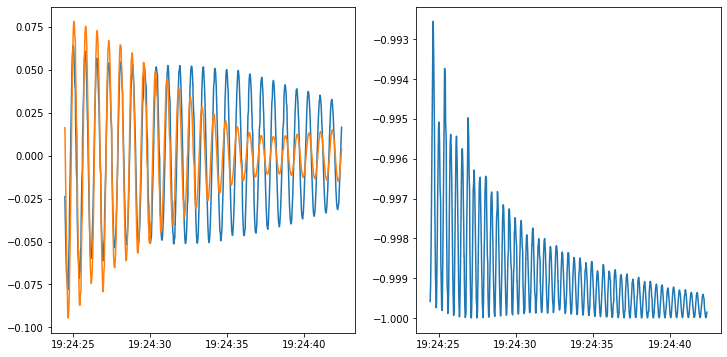

In [7]:
hx, hy = -0.01796694,  0.01110239
hz = math.sqrt(max(0, 1-hx**2-hy**2))

b = qvec((A.q0, -A.q1, -A.q2, -A.q3), (hx, hy, hz))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(b[0])
plt.plot(b[1])
plt.subplot(122)
plt.plot(b[2])
print(sum(b[0]), sum(b[1]))         

residuals  0.021846018277931735 0.022128561165039095


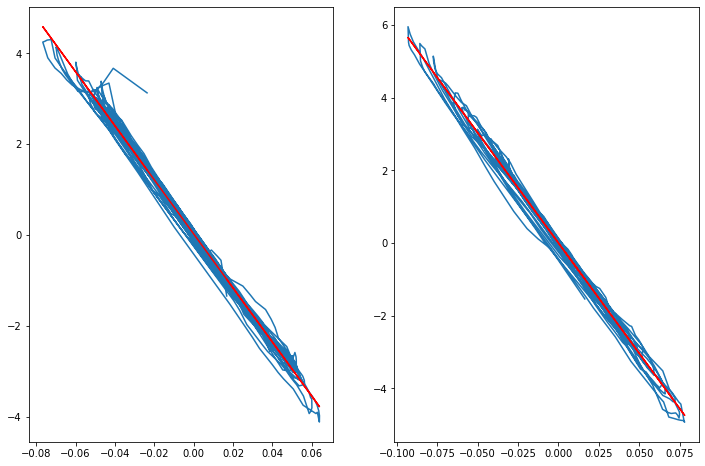

In [8]:
# Fitting the the lines to the acceleration vs position vectors
bx0, bx1, bx2 = curvefitdifferentiate(b[0], 0.18)
by0, by1, by2 = curvefitdifferentiate(b[1], 0.18)
bz0, bz1, bz2 = curvefitdifferentiate(b[2], 0.18)

plt.figure(figsize=(12,8))

plt.subplot(121)
plt.plot(bx0, bx2)

bxlm, resx = numpy.polyfit(bx0, bx2, 1, full=True)[:2]
plt.plot(bx0, numpy.poly1d(bxlm)(bx0), color="red")

plt.subplot(122)
plt.plot(by0, by2)

bylm, resy = numpy.polyfit(by0, by2, 1, full=True)[:2]
plt.plot(by0, numpy.poly1d(bylm)(by0), color="red")

print("residuals ", float(resx)/len(bx0), float(resy)/len(bx0))
# New residuals are slightly better than original  0.022094352780225236 0.022299709240590448

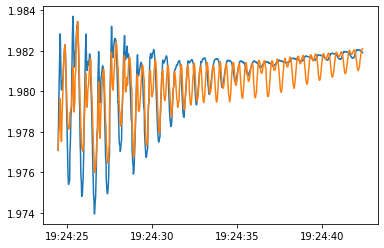

In [9]:
# What about working out the orientation with the constrained swing ax
# If oriented correctly then (q0 +- q3)**2 + (q1 + q2)**2 = 1
sp = ((A.q0 + A.q3)**2 + (A.q1 + A.q2)**2)/(A.q0**2 + A.q1**2 + A.q2**2 + A.q3**2)
sm = ((A.q0 - A.q3)**2 + (A.q1 + A.q2)**2)/(A.q0**2 + A.q1**2 + A.q2**2 + A.q3**2)
plt.plot(sp)
plt.plot(sm)


In [16]:
c = qvec((A.q0, -A.q1, -A.q2, -A.q3), (1, 0, 0))
print("Perhaps a rotation of", numpy.arctan2(c[1], c[0]).mean(), "radians")

Perhaps a rotation of 1.7649533005021318 radians


alternative configurations mean and std 0.9993892849078164 3.4138514738012946e-05 0.9999975417544057 3.808862324490705e-05


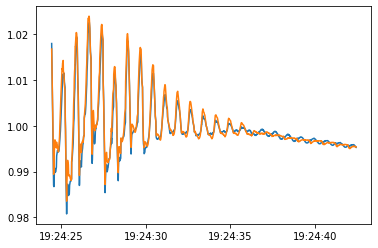

In [66]:
zrot = 1.7649533005021318/2
qr = (math.cos(zrot), 0, 0, math.sin(zrot))
q = qmult(qr, (A.q0, -A.q1, -A.q2, -A.q3))
sp = ((q[0] + q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
sm = ((q[0] - q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
plt.plot(sp)
plt.plot(sm)
print("alternative configurations mean and std", sp.mean(), ((sp-1)**2).mean(), sm.mean(), ((sm-1)**2).mean())

In [41]:
# Now can we combine these two systems together - the alignment with the pendulum 
# and the tortion of the pendulum
#hz = math.sqrt(max(0, 1-hx**2-hy**2))

# first construct the quaternion that corresponds to the h vector 
# so that we get the whole frame not just one vector
# This requires half the rotation of h to be computed

#b = qvec((A.q0, -A.q1, -A.q2, -A.q3), (hx, hy, hz))
hl = math.hypot(hx, hy)
# asin(hhl) = 0.5*asin(hl)
hhl = math.sin(0.5*math.hypot(hx, hy))
#qvec((hz, hy, -hx, 0), (0,0,1)), (hx, hy, hz)
hhfac = hhl/hl
hhx, hhy = hx*hhfac, hy*hhfac
hhz = math.sqrt(max(0, 1-hhx**2-hhy**2))
hq = (hhz, hhy, -hhx, 0)
print("Transform of z by new quaternion", qvec(hq, (0,0,1)), "\nshould match", (hx, hy, hz))


Transform of z by new quaternion (-0.017965604265669857, 0.011101564603829609, 0.999776971292456) 
should match (-0.01796694, 0.01110239, 0.9997769381233618)


errors compared to above very slightly reduced 0.9992895234589618 3.234149127292438e-05 1.0000972782976572 3.385618597559023e-05


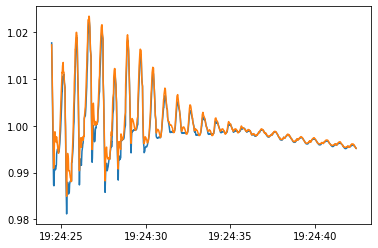

In [67]:
q = qmult(qr, qmult((A.q0, -A.q1, -A.q2, -A.q3), hq))
sp = ((q[0] + q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
sm = ((q[0] - q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
plt.plot(sp)
plt.plot(sm)
print("errors compared to above very slightly reduced", sp.mean(), ((sp-1)**2).mean(), sm.mean(), ((sm-1)**2).mean())

In [62]:
# What do these errors look like across the range of zrots
zrots = numpy.linspace(zrot-0.003, zrot+0.003, 50)
sps, sms = [ ], [ ]
spsu, smsu = [ ], [ ]
for lzrot in zrots:
    qr = (math.cos(lzrot), 0, 0, math.sin(lzrot))
    q = qmult(qr, qmult((A.q0, -A.q1, -A.q2, -A.q3), hq))
    sp = ((q[0] + q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
    sm = ((q[0] - q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
    sps.append(((sp-1)**2).mean())
    sms.append(((sm-1)**2).mean())

    q = qmult(qr, (A.q0, -A.q1, -A.q2, -A.q3))
    sp = ((q[0] + q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
    sm = ((q[0] - q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
    spsu.append(((sp-1)**2).mean())
    smsu.append(((sm-1)**2).mean())
    

It seems like the up, q0+q3 version is correct


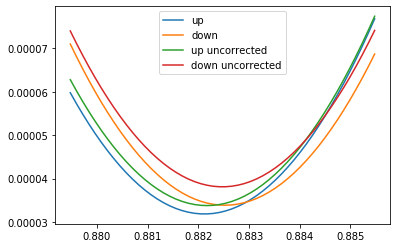

In [64]:
plt.plot(zrots, sps, label="up")
plt.plot(zrots, sms, label="down")
plt.plot(zrots, spsu, label="up uncorrected")
plt.plot(zrots, smsu, label="down uncorrected")
plt.legend()
print("It seems like the up, q0+q3 version is correct")

In [88]:
fun((hhy, -hhx, math.sin(zrot)))

3.234149127292438e-05

In [89]:
# Can we derive these three correcting values using the minimization
def fun(X):
    hqx, hqy, sinzrot = X
    lhq = (math.sqrt(max(0, 1-hqx**2-hqy**2)), hqx, hqy, 0)
    lqr = (math.sqrt(max(0, 1-sinzrot**2)), 0, 0, sinzrot)
    q = qmult(lqr, qmult((A.q0, -A.q1, -A.q2, -A.q3), lhq))
    s = ((q[0] + q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
    return ((s-1)**2).mean()
Xestimated = (hhy, -hhx, math.sin(zrot))
print("Known by eye minima:", fun(Xestimated))
res = scipy.optimize.minimize(fun, [0,0,0], method="Nelder-Mead")
print(res)
print("The estimated X is", Xestimated)

Known by eye minima: 3.234149127292438e-05
 final_simplex: (array([[ 0.13840166,  0.30681699, -0.60290957],
       [ 0.13838426,  0.30678193, -0.6028377 ],
       [ 0.13838003,  0.30676712, -0.60281342],
       [ 0.13840911,  0.30682977, -0.60294229]]), array([2.51888305e-05, 2.51911579e-05, 2.52093490e-05, 2.52124808e-05]))
           fun: 2.518883050233806e-05
       message: 'Optimization terminated successfully.'
          nfev: 105
           nit: 54
        status: 0
       success: True
             x: array([ 0.13840166,  0.30681699, -0.60290957])
The estimated X is (0.005551091823752805, 0.008983303030415724, 0.7723145140505295)


In [101]:
print("That's garbage.  What if we start it at the estimated value?\n")
res = scipy.optimize.minimize(fun, Xestimated, method="Nelder-Mead")
print(res)
print(Xestimated, fun(Xestimated))

That's garbage.  What if we start it at the estimated value?

 final_simplex: (array([[ 0.07308871, -0.05915868,  0.76849465],
       [ 0.07314052, -0.05920596,  0.76849123],
       [ 0.07318181, -0.05924226,  0.76848614],
       [ 0.07312742, -0.05921136,  0.76848956]]), array([2.03135944e-05, 2.03135962e-05, 2.03136048e-05, 2.03136104e-05]))
           fun: 2.0313594366761324e-05
       message: 'Optimization terminated successfully.'
          nfev: 116
           nit: 64
        status: 0
       success: True
             x: array([ 0.07308871, -0.05915868,  0.76849465])
(0.005551091823752805, 0.008983303030415724, 0.7723145140505295) 3.234149127292438e-05


Still total garbage; the swinging is not about the Z down vector
Conclusion:  The axis alignment is not enough to constrain the pendulum.
These components must be computed separately


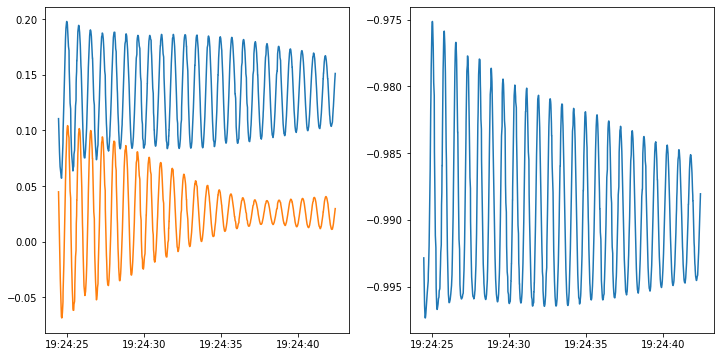

In [111]:
# Filter these numbers back into the original estimating diagrams

hqx, hqy, sinzrot = Xestimated
hqx, hqy, sinzrot = res.x
lhq = (math.sqrt(max(0, 1-hqx**2-hqy**2)), hqx, hqy, 0)
lqr = (math.sqrt(max(0, 1-sinzrot**2)), 0, 0, sinzrot)
h = qvec(lhq, (0,0,1))

b = qvec((A.q0, -A.q1, -A.q2, -A.q3), h)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(b[0])
plt.plot(b[1])
plt.subplot(122)
plt.plot(b[2])

print("Still total garbage; the swinging is not about the Z down vector")
print("Conclusion:  The axis alignment is not enough to constrain the pendulum.")
print("These components must be computed separately")

In [ ]:
# 
def fun1(X):
    
    sinzrot = X
    lhq = (math.sqrt(max(0, 1-hqx**2-hqy**2)), hqx, hqy, 0)
    lqr = (math.sqrt(max(0, 1-sinzrot**2)), 0, 0, sinzrot)
    q = qmult(lqr, qmult((A.q0, -A.q1, -A.q2, -A.q3), lhq))
    s = ((q[0] + q[3])**2 + (q[1] + q[2])**2)/(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
    return ((s-1)**2).mean()
Xestimated = (hhy, -hhx, math.sin(zrot))
print("Known by eye minima:", fun(Xestimated))
res = scipy.optimize.minimize(fun, [0,0,0], method="Nelder-Mead")
print(res)
print("The estimated X is", Xestimated)